In [1]:
from pyspark.sql import *
from pyspark.sql.functions import *

# UMAP

In [2]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Load MNIST dataset

In [3]:
"""
Load and return OpenML's MNIST database of handwritten digits with 70,000 examples and 784 features across 10 classes.
Loads the data into a pandas DataFrames with default datatype float64.
"""

#mnist = fetch_openml("mnist_784", version=1, parser='auto')
#print(mnist.data.shape)
#mnist.data.info(memory_usage='deep')

"\nLoad and return OpenML's MNIST database of handwritten digits with 70,000 examples and 784 features across 10 classes.\nLoads the data into a pandas DataFrames with default datatype float64.\n"

## Convert dataset to Spark DataFrame

#### Create Spark Session
UMAP is a driver-intensive algorithm. Be sure to allocate enough resources for the driver in the Spark config.

In [4]:
_config = {
    "spark.master": f"local[3]",
    "spark.python.worker.reuse": "false",
    "spark.driver.host": "127.0.0.1",
    "spark.task.maxFailures": "1",
    "spark.driver.memory": "15g",
    "spark.driver.maxResultSize": "0",
    "spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled": "false",
    "spark.sql.pyspark.jvmStacktrace.enabled": "true",
    # add pyarrow
}
spark = SparkSession.builder.appName("spark-rapids-ml umap")
for key, value in _config.items():
    spark = spark.config(key, value)
spark = spark.getOrCreate()

23/07/31 15:29:06 WARN Utils: Your hostname, 728fbda-lcedt resolves to a loopback address: 127.0.1.1; using 10.110.44.254 instead (on interface enp1s0)
23/07/31 15:29:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/31 15:29:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
#df = spark.createDataFrame(mnist.data)
#print(df.rdd.getNumPartitions())
#df.printSchema()

## Spark RAPIDS ML (GPU)

In [6]:
from spark_rapids_ml.umap import UMAP

In [7]:
#feature_cols = [f"pixel{i}" for i in range(1, mnist.data.shape[1] + 1)]
#umap_estimator = UMAP(num_workers=8).setFeaturesCols(feature_cols)

data_df = spark.read.parquet("../python/benchmark/blobs_100k_3k_f64.parquet")
features_cols = [f"c{i}" for i in range(3000)]
umap_estimator = UMAP(sample_fraction=1.0, num_workers=5).setFeaturesCols(
    features_cols
)

In [8]:
data_df.cache()
data_df.show()

23/07/31 15:29:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/07/31 15:29:15 WARN DAGScheduler: Broadcasting large task binary with size 1225.0 KiB


+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+--------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+--------------------+------------------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------

### Fit
Note that fit is executed on a single node, as multi-node fitting is not yet supported.

In [9]:
start_time = time.time()
umap_model = umap_estimator.fit(data_df)
print(f"total time: {time.time() - start_time} sec")

setting up call_cuml fit func
entering call_cuml_fit_func


done in 25.980268239974976  sec
evaluating rdd, invoking fit


2023-07-31 15:29:56,291 - spark_rapids_ml.umap.UMAP - INFO - Initializing cuml context
2023-07-31 15:29:58,458 - spark_rapids_ml.umap.UMAP - INFO - Loading data into python worker memory
invoking cuml fit after 38.69013953208923  sec
2023-07-31 15:30:07,810 - spark_rapids_ml.umap.UMAP - INFO - Invoking cuml fit
2023-07-31 15:30:07,811 - spark_rapids_ml.umap.UMAP - INFO - Cuml fit complete
doing concat and fit
fit in: 7.025487422943115 sec
making pdf
made pdf in: 0.6209976673126221 sec
making pdf
made pdf in: 0.8803198337554932 sec
making pdf
made pdf in: 0.751582145690918 sec
making pdf
made pdf in: 0.7290968894958496 sec
making pdf
made pdf in: 0.7335617542266846 sec
fit returning at 1690842627.991239


finished fit in: 48.556989669799805 sec
returned to driver at 1690842643.658167
total time: 75.18402004241943 sec


#### Saving and loading
The UMAP estimator and model can be persisted using the PySpark save() API. Below is an example of saving and loading the model after fitting.

In [10]:
'''
model_path = "/tmp/umap-model"
umap_model.write().overwrite().save(model_path)
umap_model_loaded = umap_model.load(model_path)
print("Model embedding shape:", len(umap_model_loaded.embedding), ",", len(umap_model_loaded.embedding[0]))
'''

'\nmodel_path = "/tmp/umap-model"\numap_model.write().overwrite().save(model_path)\numap_model_loaded = umap_model.load(model_path)\nprint("Model embedding shape:", len(umap_model_loaded.embedding), ",", len(umap_model_loaded.embedding[0]))\n'

### Transform

In [10]:
start_time = time.time()
df_output = umap_model.transform(data_df)
df_output.cache()
df_output.count()
print(f"Transform took: {time.time() - start_time} sec")

pre process and get funcs
preprocessed in 4.396266222000122 seconds


constructing umap model                                            (0 + 3) / 13]
constructing umap model
constructing umap model
model constructed in: 5.682126045227051 sec
model constructed in: 5.70652174949646 sec


model constructed in: 5.699571371078491 sec

concating data and doing transformconcating data and doing transform

concating data and doing transform
begin transform internal
begin transform internal
begin transform internal
result computed in: 3.5394017696380615 sec, returning
yielding after 5.766450643539429 seconds
result computed in: 3.425377130508423 sec, returning
yielding after 5.781171083450317 seconds
result computed in: 3.455824136734009 sec, returning
yielding after 5.819742202758789 seconds
constructing umap modelconstructing umap modelconstructing umap model + 3) / 13]


model constructed in: 3.0201961994171143 sec
model constructed in: 3.0201947689056396 sec


concating data and doing transformconcating data and doing transform

model constructed in: 3.02336

Transform took: 162.71627283096313 sec


#### Visualize embeddings
Notice that UMAP groups individual digit classes while retaining the global structure among different digit classes. 
Groups of digits that may blend together, such as (4, 9) and (3, 5, 8) are embedded near each other, while distinct digits such as (0, 1) are placed far from each other.

/tmp/ipykernel_441979/4022340989.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], cmap="Spectral", s=0.1)


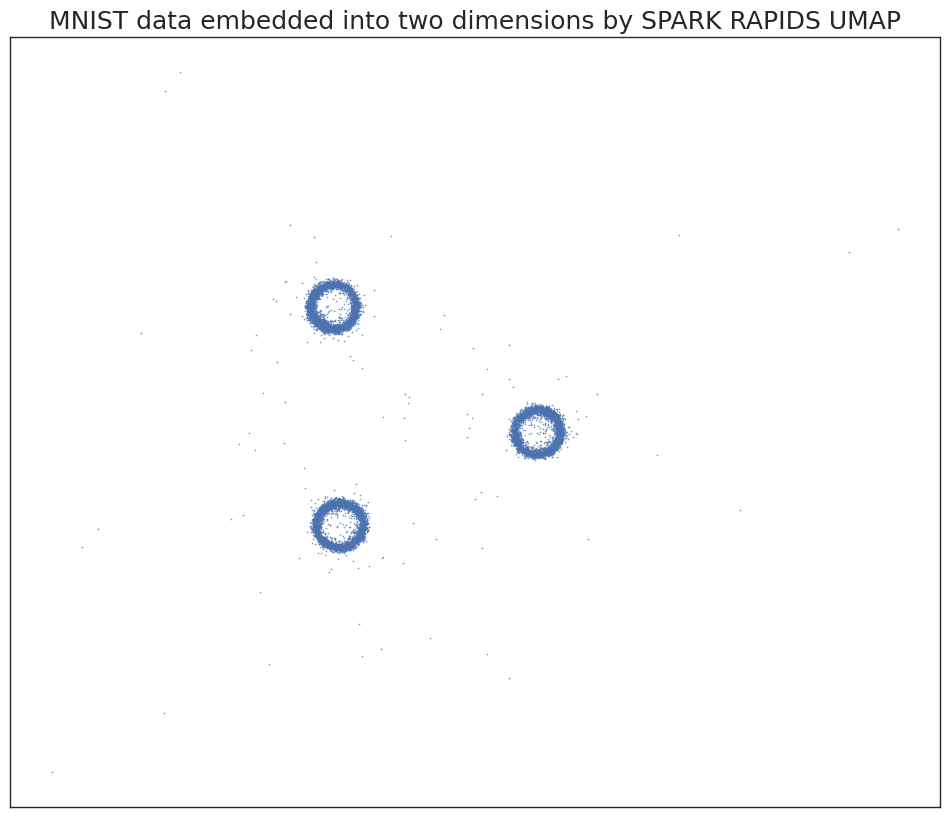

/tmp/ipykernel_441979/4022340989.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Spectral", 10)


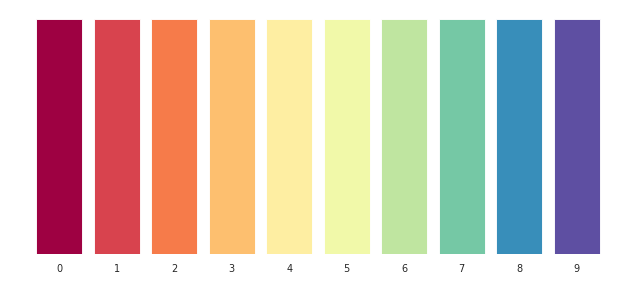

In [11]:
pd_output = df_output.toPandas()
embedding = np.array(pd_output["embedding"].to_list())

# Plot the transformed embeddings
sns.set(context="paper", style="white")
fig, ax = plt.subplots(figsize=(12, 10))
#color = data_df.select("label").toPandas()
plt.scatter(embedding[:, 0], embedding[:, 1], cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by SPARK RAPIDS UMAP", fontsize=18)
plt.show()

# Plot the digit colors
cmap = plt.cm.get_cmap("Spectral", 10)
fig, ax = plt.subplots(1, 1, figsize=(10, 4),
                        dpi=80, facecolor='w', edgecolor='k')
for sp in ax.spines.values():
    sp.set_visible(False)
bars = ax.bar(np.arange(10), [1]*10, color=[cmap(i/9) for i in range(10)])
plt.xticks(np.arange(10), np.arange(10))
ax.set_yticks([])
plt.show()

## UMAP (Local, CPU)

In [11]:
%pip install umap-learn
import umap as local_umap

Note: you may need to restart the kernel to use updated packages.


/home/rishic/anaconda3/envs/rapids-23.06/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rishic/anaconda3/envs/rapids-23.06/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rishic/anaconda3/envs/rapids-23.06/lib/python3.9/site-

In [12]:
local_umap = local_umap.UMAP()

### Fit + Transform

In [13]:
blobs = data_df.toPandas().to_numpy()
start_time = time.time()
local_umap.fit(blobs)
print(f"Fit took: {time.time() - start_time} sec")

Fit took: 42.14546489715576 sec


In [14]:
start_time = time.time()
embedding = local_umap.transform(blobs)
print(f"Transform took: {time.time() - start_time} sec")

Transform took: 0.9814770221710205 sec


/tmp/ipykernel_441979/1198098735.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], cmap="Spectral", s=0.1)


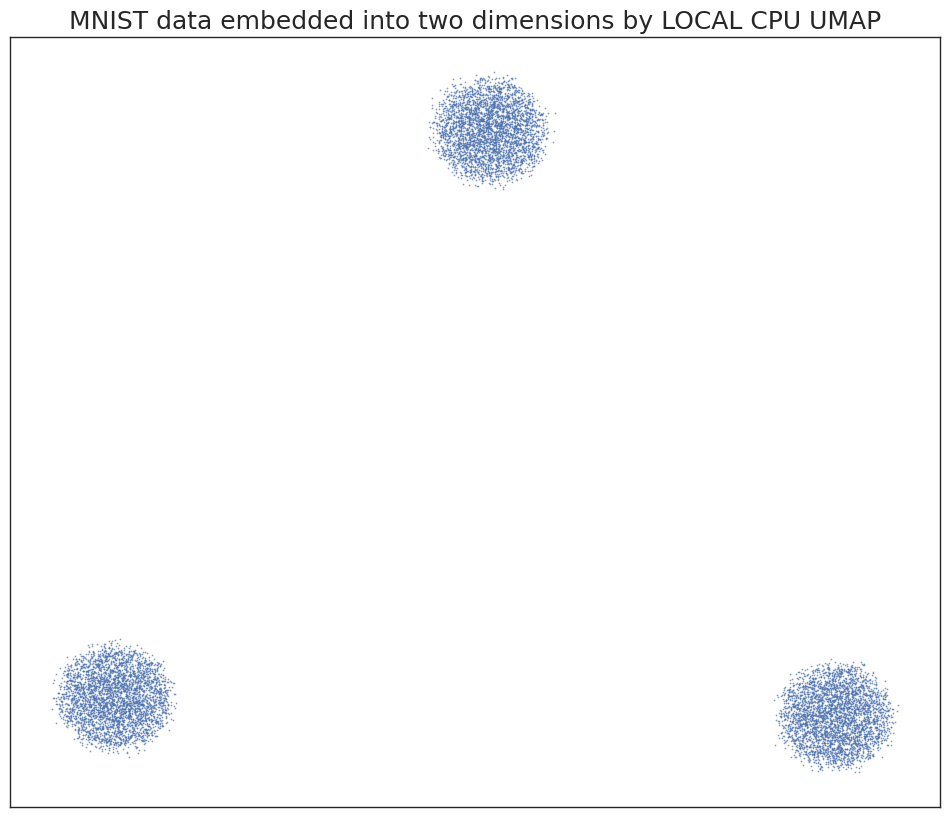

/tmp/ipykernel_441979/1198098735.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Spectral", 10)


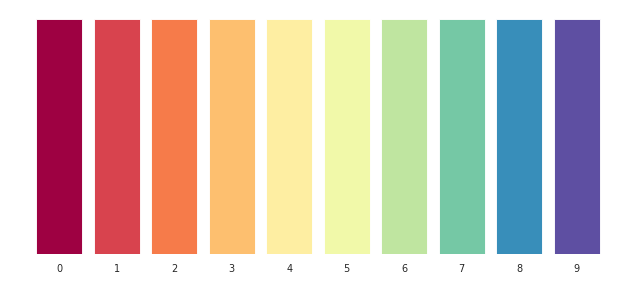

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
#color = mnist.target.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by LOCAL CPU UMAP", fontsize=18)
plt.show()

# Plot the digit colors
cmap = plt.cm.get_cmap("Spectral", 10)
fig, ax = plt.subplots(1, 1, figsize=(10, 4),
                        dpi=80, facecolor='w', edgecolor='k')
for sp in ax.spines.values():
    sp.set_visible(False)
bars = ax.bar(np.arange(10), [1]*10, color=[cmap(i/9) for i in range(10)])
plt.xticks(np.arange(10), np.arange(10))
ax.set_yticks([])
plt.show()

In [17]:
print(blobs.shape)

(11000, 3000)


In [15]:
from cuml.manifold import UMAP as cuml_UMAP

In [16]:
#mnist_np = mnist.data.to_numpy()

In [17]:
cuml_umap = cuml_UMAP()
start_time = time.time()
cuml_umap.fit(blobs)
print(f"Fit took: {time.time() - start_time} sec")

Fit took: 6.423580884933472 sec


In [18]:
start_time = time.time()
embedding = cuml_umap.transform(blobs)
print(f"Transform took: {time.time() - start_time} sec")

Transform took: 3.505039930343628 sec


/tmp/ipykernel_2507969/1621527866.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], cmap="Spectral", s=0.1)


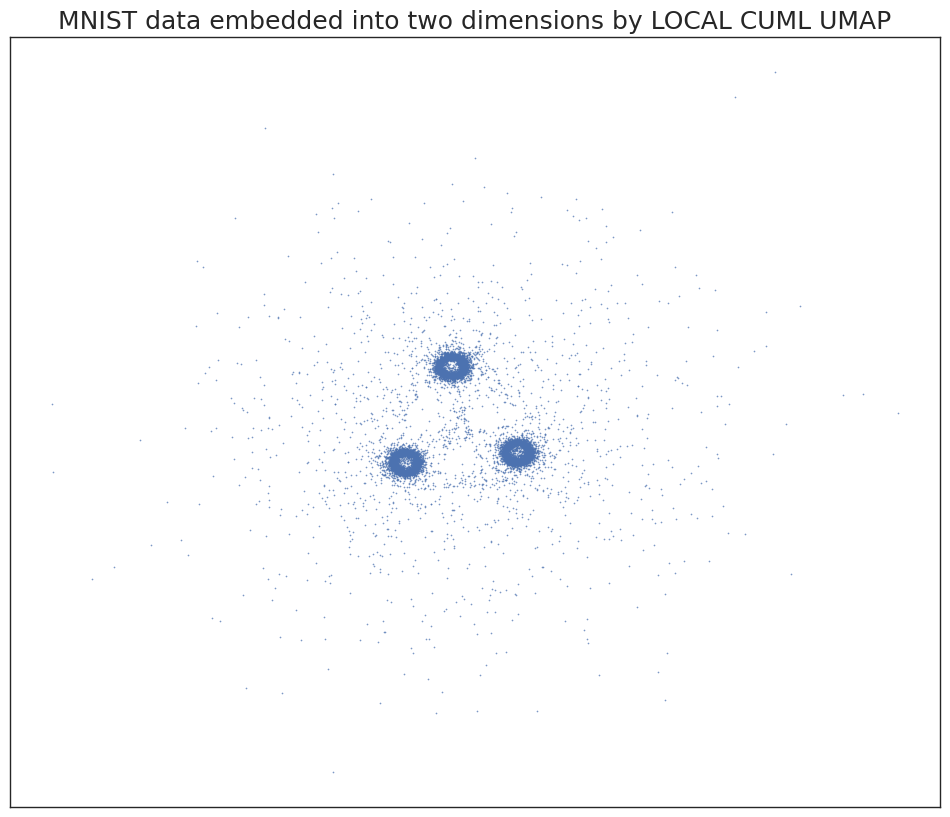

In [38]:
fig, ax = plt.subplots(figsize=(12, 10))
#color = mnist.target.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by LOCAL CUML UMAP", fontsize=18)
plt.show()

In [19]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
import dask.array as da
import dask.dataframe as dd
from cuml.dask.manifold import UMAP as MNMG_UMAP
import numpy as np

In [20]:
cluster = LocalCUDACluster(threads_per_worker=1)
client = Client(cluster)

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:36065
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43135'
2023-07-31 15:15:38,747 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-07-31 15:15:38,747 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:43063', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:43063
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:47556
INFO:distributed.scheduler:Receive client connection: Client-c7bf4e20-2fef-11ee-9fdc-047bcba501da
INFO:distr

In [21]:
distributed_model = MNMG_UMAP(model=cuml_umap)
import cupy as cp

In [22]:
#distributed_X = da.from_array(cp.array(blobs), chunks=(2000, -1))
distributed_df = dd.read_parquet("../python/benchmark/blobs_100k_3k_f64.parquet")
distributed_X = distributed_df.to_dask_array(lengths=True)
distributed_X = distributed_X.map_blocks(cp.asarray)

start_time = time.time()
embedding_cp = distributed_model.transform(distributed_X).compute()
print(f"Transform took: {time.time() - start_time} sec")
embedding = embedding_cp.get()

Transform took: 19.563567638397217 sec


/tmp/ipykernel_2470056/326002955.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], cmap="Spectral", s=0.1)


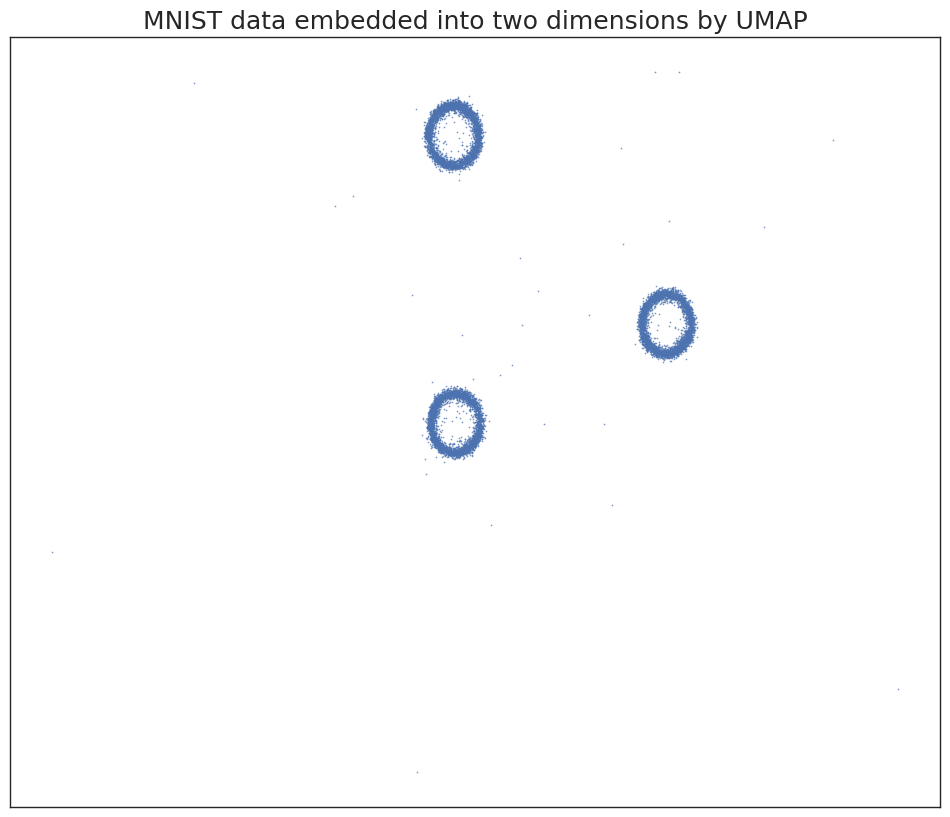

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
#color = mnist.target.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by DASK CUML UMAP", fontsize=18)
plt.show()

In [ ]:
print(np.array_equal(umap_model.embedding, cuml_umap.embedding_))
print(umap_model.embedding[:5])
print(cuml_umap.embedding_.tolist()[:5])

False
[[-7.160271644592285, -0.6556200981140137], [2.8538026809692383, 6.42231559753418], [-6.890644073486328, -0.8553485870361328], [1.7838735580444336, 6.4802656173706055], [-7.9702301025390625, 0.5847234725952148]]
[[-3.104307174682617, -5.3425445556640625], [7.670541763305664, -1.6457996368408203], [-2.9591941833496094, -5.426521301269531], [7.6257219314575195, -0.8374958038330078], [-4.092516899108887, -5.0720062255859375]]
